In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from skimage.filters import sobel
from kornia.filters import Canny, sobel   # use directly on tensors
from skimage import color, data
from skimage.transform import resize
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skorch import NeuralNet, NeuralNetRegressor
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from tqdm.auto import tqdm

from src.dataset_benchm import OVAS, all_datasets
from src.train import eval_loop

/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = OVAS('test', expand=False)
# dataset = Subset(dataset, np.arange(20))

In [3]:
CSV_FILE = 'grid_metrics_sobel.csv'

In [4]:
class ThresholdModel(nn.Module):
    def __init__(self, t=.5):
        super(ThresholdModel, self).__init__()
        self.t = torch.tensor([t])

    def forward(self, x):
        sobimg = sobel(x[:, 1:2, :, :])
        out = sobimg > self.t.item()
        return  out.float()

In [5]:
[i.size() for i in dataset[0]]

[torch.Size([4, 256, 256]), torch.Size([1, 256, 256])]

In [6]:
ind = np.random.choice(range(len(dataset)))
ind = np.int64(484)

/tmp/54227353/ipykernel_3808303/3742320867.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axes[0].imshow(np.array(image))


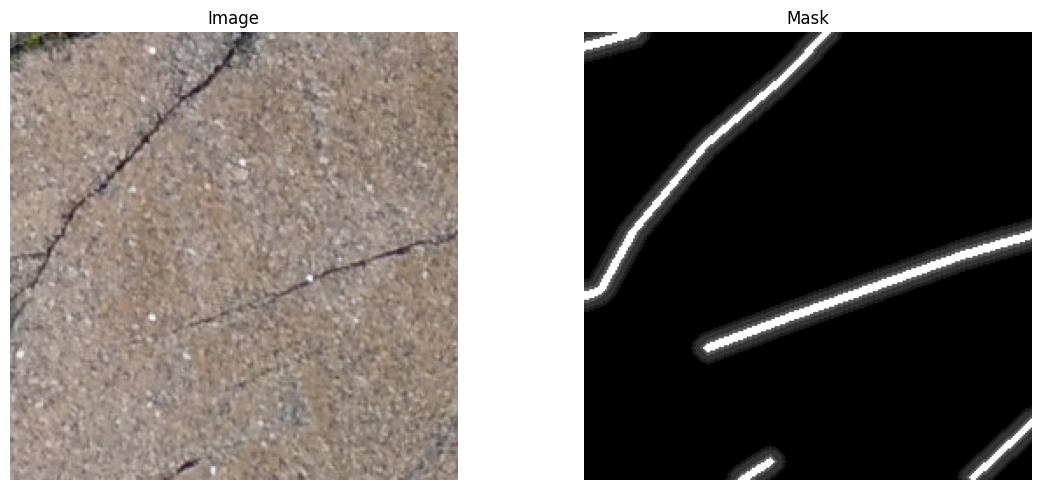

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
image = dataset[ind][0].permute(1, 2, 0)[:, :, :3] / 255.
mask = dataset[ind][1].permute(1, 2, 0)

axes[0].imshow(np.array(image))
axes[0].set_title('Image')
axes[0].axis('off')
axes[0].grid([])

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
axes[1].grid([])

fig.tight_layout()

In [8]:
model_ = ThresholdModel(t=0.)

In [9]:
pred = model_(dataset[ind][0].unsqueeze(0))

In [10]:
dataset[ind][0].shape

torch.Size([4, 256, 256])

In [11]:
sobel_ = sobel(dataset[ind][0].unsqueeze(0))
sobel_.shape

torch.Size([1, 4, 256, 256])

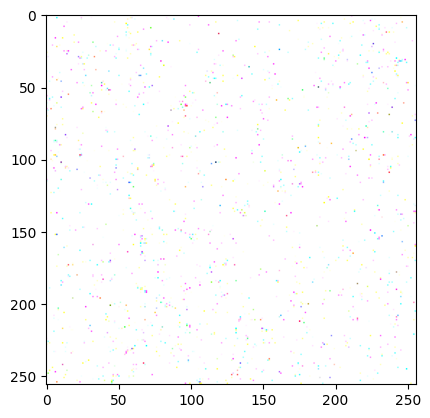

In [12]:
plt.imshow(sobel_.squeeze(0).permute(1, 2, 0)[:, :, :3])

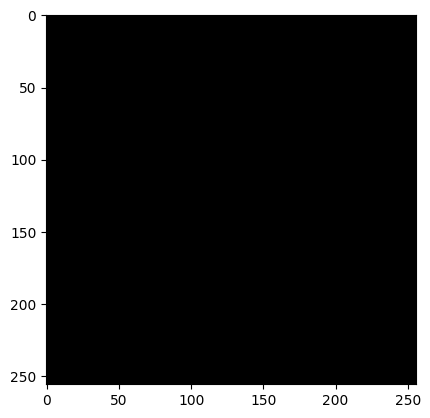

In [13]:
plt.imshow(pred.squeeze(0,1), cmap='gray')

In [14]:
CALCULATED_METRICS = ('mse', 'psnr', 'ssim', 'ae', 'acc', 'f1', 'prec', 'rec', 'roc_auc', 'iou_nbg', 'loss')

In [15]:
class Estimator(BaseEstimator):
    def __init__(self, threshold=.5, lr=1e-3, epochs=1, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold

    def fit(self, X, y=None):
        dataset = X
        valloader = DataLoader(dataset, batch_size=self.batch_size)
        self.model = ThresholdModel(t=self.threshold).cuda()
        criterion = nn.HuberLoss()

        # Evaluate on val set for scoring
        self.model.eval()
        scheduler = None
        self.metrics = eval_loop(self.model, scheduler, criterion, valloader,
                            self.threshold, 'cuda')
        self.val_accuracy = self.metrics['f1'] + self.metrics['roc_auc'] + self.metrics['iou_nbg']
        print(f'Val accuracy: {self.val_accuracy}')        

        return self

    def score(self, X, y=None):
        row = {
            'threshold': self.threshold,
            'lr': self.lr,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            **self.metrics
        }

        df = pd.DataFrame([row])
        if not os.path.exists(CSV_FILE):
            df.to_csv(CSV_FILE, index=False)
        else:
            df.to_csv(CSV_FILE, mode='a', header=False, index=False)

        return self.val_accuracy

In [ ]:
param_grid = {
    'threshold': np.arange(0, 1, 0.1),
}

grid = GridSearchCV(Estimator(), param_grid, scoring=None, cv=2)
grid.fit(dataset)

print(grid.best_params_)
print(grid.best_score_)

Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.31s/it]


Val accuracy: 0.861204933159791


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.29s/it]


Val accuracy: 0.8463063043924987


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.30s/it]


Val accuracy: 0.8441133135418151


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:21<00:00,  1.29s/it]


Val accuracy: 0.8408045765488015


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:21<00:00,  1.28s/it]


Val accuracy: 0.864185746557471


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.39s/it]


Val accuracy: 0.8615880065726842


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.33s/it]


Val accuracy: 0.8469116887982059


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8446999455764465


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8409261357288481


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Val accuracy: 0.8647161584372084


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.36s/it]


Val accuracy: 0.8616599181627391


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.847255872220131


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.38s/it]


Val accuracy: 0.8449594064158934


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8409946684255806


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.35s/it]


Val accuracy: 0.8648693342495648


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8617486424649714


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8475847569934756


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Val accuracy: 0.8452246825055728


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Val accuracy: 0.8410861346085328


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8650367559074161


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.33s/it]


Val accuracy: 0.8620136888025276


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.33s/it]


Val accuracy: 0.8484784319074286


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.38s/it]


Val accuracy: 0.845941813356456


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8413194939608524


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Val accuracy: 0.8654905761078469


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8620136888025276


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.33s/it]


Val accuracy: 0.8484784319074286


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.845941813356456


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8413194939608524


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8654905761078469


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Val accuracy: 0.8623908409857705


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8498138555957513


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:22<00:00,  1.34s/it]


Val accuracy: 0.8470057113466611


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:23<00:00,  1.36s/it]


Val accuracy: 0.8416605974163015


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:27<00:00,  1.64s/it]


Val accuracy: 0.8661813619661981


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.66s/it]


Val accuracy: 0.8625730471560857


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:35<00:00,  2.11s/it]


Val accuracy: 0.850343330383767


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:46<00:00,  2.72s/it]


Val accuracy: 0.847450537254499


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:46<00:00,  2.75s/it]


Val accuracy: 0.8418361734775834


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.68s/it]


Val accuracy: 0.8664527319846324


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.70s/it]


Val accuracy: 0.8632803839284431


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.69s/it]


Val accuracy: 0.8519489802679138


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:46<00:00,  2.73s/it]


Val accuracy: 0.8488231621983273


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:46<00:00,  2.71s/it]


Val accuracy: 0.8424918702683126


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:46<00:00,  2.72s/it]


Val accuracy: 0.8673854820345175


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.66s/it]


Val accuracy: 0.8636379031030775


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.66s/it]


Val accuracy: 0.8527453969053929


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.70s/it]


Val accuracy: 0.849528382311559


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.70s/it]


Val accuracy: 0.8428475931910032


Iterating over evaluation data: 100%|██████████████████████████████| 17/17 [00:45<00:00,  2.68s/it]


Val accuracy: 0.8678482945618567


Iterating over evaluation data: 100%|██████████████████████████████| 21/21 [01:30<00:00,  4.33s/it]

Val accuracy: 0.856201715862481
{'threshold': np.float64(0.9)}
0.8553215140145779


In [17]:
import pandas as pd

df = pd.read_csv(CSV_FILE)

keep_indices = []
i = 0
while i < len(df):
    keep_indices.append(i)
    i += 5  # skip 4, move to next keep

df_filtered = df.iloc[keep_indices].reset_index(drop=True)
df_filtered.to_csv(CSV_FILE, index=False)

grid.cv_results_['mean_test_score']

grid.cv_results_['params']